<img src='https://raw.githubusercontent.com/autonomio/hyperio/master/logo.png' width=250px>

In [1]:
import talos
import pandas as pd

%matplotlib inline

Using TensorFlow backend.


## Table of Contents

##### 1. <a href=#one>Data Preparation</a>
##### 2. <a href=#two>Model Preparation</a>
##### 3. <a href=#three>Setting the Parameter Space Boundaries</a>
##### 4. <a href=#four>Run the Hyperparameter <code>Scan()</code></a>
##### 5. <a href=#five>Access the results through the <code>Scan</code> object</a>
##### 6. <a href=#six>Analysing the Scan results with <code>Reporting()</code></a>
##### 7. <a href=#seven>Evaluating Models with <code>Evaluate()</code></a>
##### 8. <a href=#eight>Deploying Models with <code>Deploy()</code></a>
##### 9. <a href=#nine>Restoring Models with <code>Restore()</code></a>

### 1. Data Preparation <a name="one"></a> 

For this experiment, we're going to use the famous Iris dataset. 

In [2]:
x, y = talos.templates.datasets.iris()

### 2. Model Preparation  <a name="two"></a> 
Talos works with any Keras model, without changing the structure of the model in anyway, or without introducing any new syntax. The below example shows clearly how this works. 

For this example, we have to import two helper functions from Talos, one for early stopping callout, and the other for using normalized learning rate values. Because we might want to work on trying out several optimizers in a single scan, without normalization, inputting of the values would become cumbersome.

In [3]:
from talos.utils import lr_normalizer

Note that the only difference in the model below is how instead of using a label or value to define a given model parameter, we do it using a dictionary label. Also for optimizer we are using a learning rate parameter, which involves the use of two dictionary labels.

In [4]:
from keras.models import Sequential
from keras.layers import Dropout, Dense

def iris_model(x_train, y_train, x_val, y_val, params):
    
    model = Sequential()                            
    model.add(Dense(params['first_neuron'],
                    input_dim=x_train.shape[1],
                    activation='relu'))
    
    model.add(Dropout(params['dropout']))
    model.add(Dense(y_train.shape[1],
                    activation=params['last_activation']))

    model.compile(optimizer=params['optimizer'](lr=lr_normalizer(params['lr'], params['optimizer'])),
                  loss=params['loss'],
                  metrics=['acc'])

    out = model.fit(x_train, y_train,
                    batch_size=params['batch_size'],
                    epochs=params['epochs'],
                    verbose=0,
                    validation_data=[x_val, y_val])
    
    return out, model

### 3. Setting the Parameter Space Boundaries <a name="three"></a> 
In the last and final step, we're going to create the dictionary, which will then be passed on to Talos together with the model above. Here we have three different ways to input values:

- as stepped ranges (min, max, steps)
- as multiple values [in a list]
- as a single value [in a list]

For values we don't want to use, it's ok to set it as None.

NOTE: at this point you have to import from Keras the optimizer, activations, and losses you want to scan for.

In [5]:
from keras.optimizers import Adam, Nadam
from keras.activations import softmax
from keras.losses import categorical_crossentropy, logcosh

p = {'lr': (0.1, 10, 10),
     'first_neuron':[4, 8, 16, 32, 64, 128],
     'batch_size': [2, 3, 4],
     'epochs': [200],
     'dropout': (0, 0.40, 10),
     'optimizer': [Adam, Nadam],
     'loss': ['categorical_crossentropy'],
     'last_activation': ['softmax'],
     'weight_regulizer': [None]}

### 4. Run the Hyperparameter <code>Scan()</code> <a name="four"></a> 
Now we are ready to run the model based on the parameters and the layer configuration above. The exact same process would apply with any other model, just make sure to pass the model function name in the Scan() command as in the below example. To get started quickly, we're going to invoke the 'grid_downsample' parameter to 1/100 of the entire permutations.

In [6]:
scan_object = talos.Scan(x,
                         y, 
                         params=p,
                         model=iris_model,
                         experiment_name='iris',
                         fraction_limit=.001)

100%|██████████| 3/3 [00:25<00:00,  8.49s/it]


### 5. Access the results through the <code>Scan</code> object <a name="five"></a> 

In [8]:
# accessing the results data frame
scan_object.data.head()

# accessing epoch entropy values for each round
scan_object.learning_entropy

# access the summary details
scan_object.details

   round_epochs  val_loss   val_acc      loss       acc  batch_size  dropout  \
0           200  0.196426  0.977778  0.427386  0.771429           2     0.32   
1           200  0.182282  0.933333  0.092463  0.980952           3     0.16   
2           200  0.116601  0.933333  0.082208  0.971429           2     0.36   

   epochs  first_neuron last_activation                      loss    lr  \
0     200             8         softmax  categorical_crossentropy  4.06   
1     200            16         softmax  categorical_crossentropy  7.03   
2     200            32         softmax  categorical_crossentropy  3.07   

                          optimizer weight_regulizer  
0  <class 'keras.optimizers.Nadam'>             None  
1  <class 'keras.optimizers.Nadam'>             None  
2  <class 'keras.optimizers.Nadam'>             None  


experiment_name                    iris
random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
reduction_threshold                 0.2
reduction_metric                val_acc
complete_time            11/15/19/12:22
x_shape                        (150, 4)
y_shape                        (150, 3)
dtype: object

In addition to statistics and meta-data related with the Scan, the used data (x and y) together with the saved model and model weights for each hyperparameter permutation is stored in the Scan object. 

In [9]:
# accessing the saved models
scan_object.saved_models

# accessing the saved weights for models
scan_object.saved_weights

[[array([[-6.7165035e-01, -2.6424018e-01, -4.5079038e-01, -4.2806730e-02,
          -3.7372541e-01, -2.6941356e-01, -2.8734407e-01, -5.5351496e-01],
         [-1.0485907e+00,  3.1507939e-01,  1.4311469e-01,  1.1568025e+00,
           5.1612824e-01,  1.2228505e-01, -3.5252213e-01, -8.7008506e-01],
         [ 1.2110327e+00, -3.8799360e-01, -3.7157640e-01, -5.3956354e-01,
           1.4614017e-03,  4.0592036e-01, -5.1203161e-01,  1.2053699e+00],
         [ 1.9058460e+00,  6.9271535e-01,  1.6160047e-01, -1.8587023e+00,
          -1.9171296e-01, -5.7453185e-01, -5.9432852e-01,  2.3225279e+00]],
        dtype=float32),
  array([-1.781821  ,  0.        ,  0.        ,  0.43290445, -0.17280588,
         -0.0127013 ,  0.        , -1.661433  ], dtype=float32),
  array([[-8.972377  , -0.9833832 ,  2.2459407 ],
         [ 0.1183241 , -0.13187248,  0.5064724 ],
         [ 0.7377797 ,  0.6353039 , -0.32688528],
         [ 2.0960648 , -1.1195903 , -0.746247  ],
         [-0.53324413, -0.6578035 ,  0.2

The Scan object can be further used, and is required, as input for Predict(), Evaluate(), and Deploy(). More about this in the corresponding sections below.

### 6. Analysing the Scan results with <code>Reporting()</code> <a name="six"></a> 

In the Scan process, the results are stored round-by-round in the corresponding experiment log which is a .csv file stored in the present working directory. The Reporting() accepts as its source either a file name, or the Scan object. 

In [10]:
# use Scan object as input
analyze_object = talos.Analyze(scan_object)

In [11]:
# access the dataframe with the results
analyze_object.data

,round_epochs,val_loss,val_acc,loss,acc,batch_size,dropout,epochs,first_neuron,last_activation,loss,lr,optimizer,weight_regulizer
0,200,0.196426,0.977778,0.427386,0.771429,2,0.32,200,8,softmax,categorical_crossentropy,4.06,<class 'keras.optimizers.Nadam'>,None
1,200,0.182282,0.933333,0.092463,0.980952,3,0.16,200,16,softmax,categorical_crossentropy,7.03,<class 'keras.optimizers.Nadam'>,None
2,200,0.116601,0.933333,0.082208,0.971429,2,0.36,200,32,softmax,categorical_crossentropy,3.07,<class 'keras.optimizers.Nadam'>,None


In [12]:
# get the number of rounds in the Scan
analyze_object.rounds()

# get the highest result for any metric
analyze_object.high('val_acc')

# get the round with the best result
analyze_object.rounds2high('val_acc')

# get the best paramaters
analyze_object.best_params('val_acc', ['acc', 'loss', 'val_loss'])

# get correlation for hyperparameters against a metric
analyze_object.correlate('val_loss', ['acc', 'loss', 'val_loss'])

round_epochs         NaN
val_acc         0.636845
batch_size      0.349276
dropout        -0.520062
epochs               NaN
first_neuron   -0.986142
lr              0.564116
Name: val_loss, dtype: float64

In addition to the key obsevations, several useful plots are available for analysis of the results.

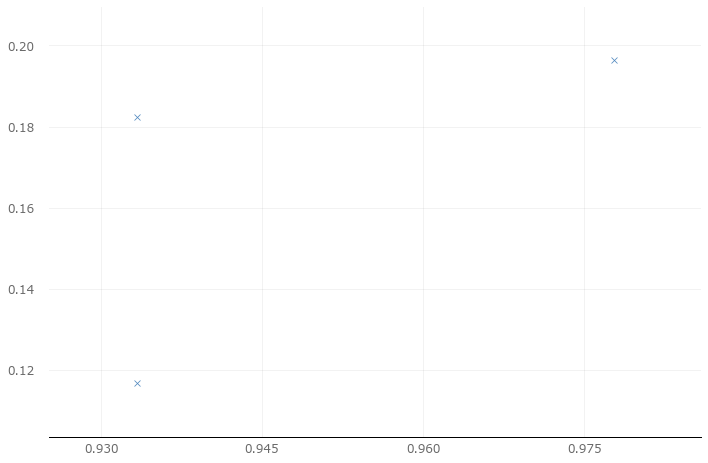

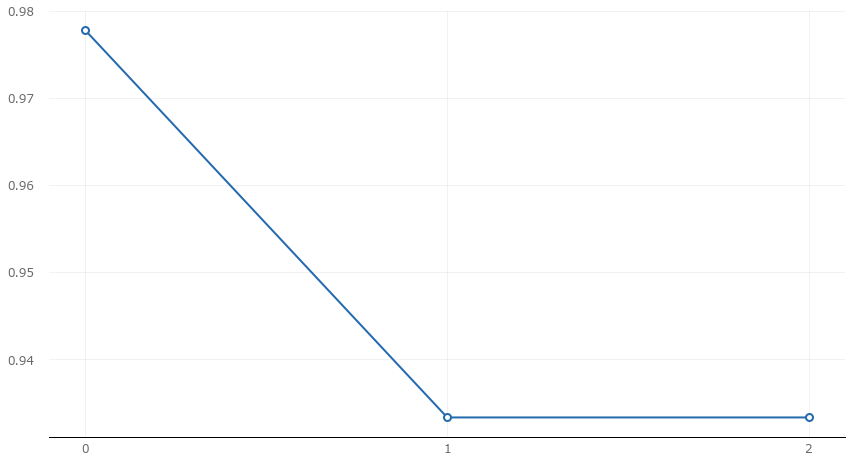

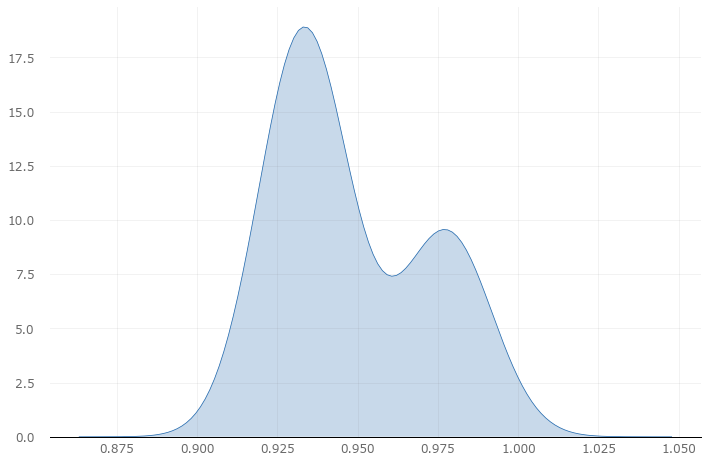

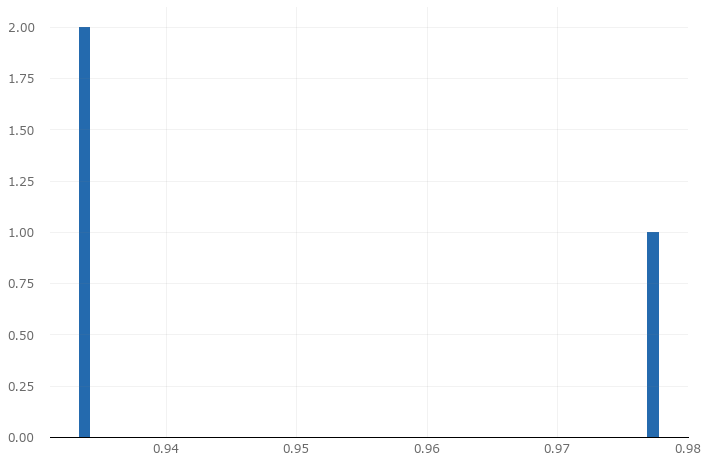

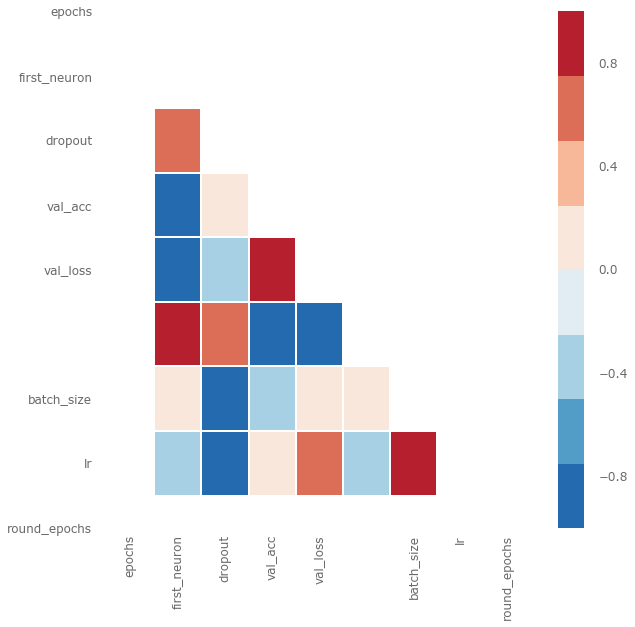

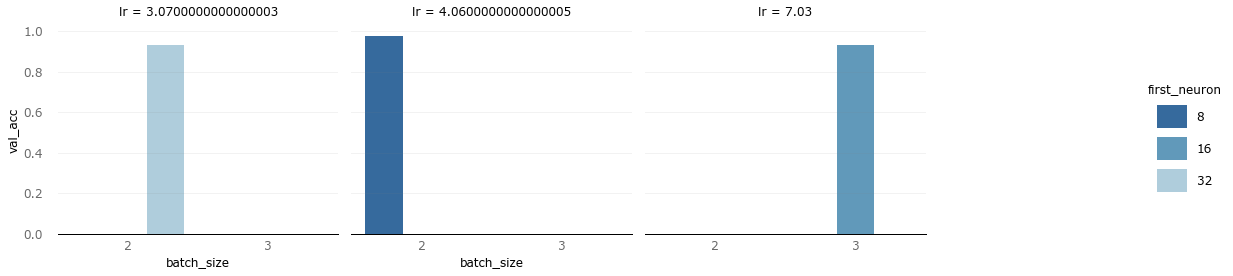

In [13]:
# a regression plot for two dimensions 
analyze_object.plot_regs('val_acc', 'val_loss')

# line plot
analyze_object.plot_line('val_acc')

# up to two dimensional kernel density estimator
analyze_object.plot_kde('val_acc')

# a simple histogram
analyze_object.plot_hist('val_acc', bins=50)

# heatmap correlation
analyze_object.plot_corr('val_loss', ['acc', 'loss', 'val_loss'])

# a four dimensional bar grid
analyze_object.plot_bars('batch_size', 'val_acc', 'first_neuron', 'lr')

### 7. Evaluating Models with <code>Evaluate()</code> <a name="seven"></a> 

Models can be evaluated with <code>Evaluate()</code> against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the <code>Scan</code> process and only exposed into Evaluate once one or more candidate models have been identified.

In [14]:
evaluate_object = talos.Evaluate(scan_object)
evaluate_object.evaluate(x, y, folds=10, metric='val_acc', task='multi_label')

[1.0,
 1.0,
 0.9393939393939394,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9220779220779222,
 1.0]

Once a sufficiently performing model have been found, a deployment package can be easily created.

### 8. Deploying Models with <code>Deploy()</code> <a name="eight"></a> 

Once the right model or models have been found, you can create a deployment package with <code>Deploy()</code> which is then easy to transfer to a production or other environment, send via email, or upload to shared remote location. Best model is automatically chosen based on a given metric ('val_acc' by default).

The Deploy package is a zip file that consist of: 

- details of the scan
- model weights
- model json
- results of the experiment
- sample of x data
- sample of y data

The <code>Deploy</code> package can be easily restored with <code>Restore()</code> which is covered in the next section.

In [16]:
talos.Deploy(scan_object=scan_object, model_name='iris_deploy', metric='val_acc');

Deploy package iris_deploy have been saved.


### 9. Restoring Models with <code>Restore()</code> <a name="nine"></a> 

Models can be evaluated with <code>Evaluate()</code> against a k-fold cross-validation. Ideally at least 50% of the data, or more if possible, is kept completely out of the <code>Scan</code> process and only exposed into Evaluate once one or more candidate models have been identified.

In [17]:
iris = talos.Restore('iris_deploy.zip')

The <code>Restore</code> object now consists of the assets from the Scan object originally associated with the experiment, together with the model that had been picked as 'best'. The model can be immediately used for making prediction, or use in any other other way Keras model objects can be used.

In [18]:
# make predictions with the model
iris.model.predict(x)

array([[2.24559917e-04, 8.08504462e-01, 1.91270977e-01],
       [6.20677928e-03, 8.46851766e-01, 1.46941483e-01],
       [1.25033468e-01, 7.74674296e-01, 1.00292280e-01],
       [9.99924898e-01, 5.60341832e-05, 1.91252384e-05],
       [9.99393106e-01, 4.79392591e-04, 1.27521605e-04],
       [9.99930620e-01, 5.16241598e-05, 1.77885377e-05],
       [3.32180392e-32, 1.42759700e-05, 9.99985695e-01],
       [9.99913812e-01, 6.45297987e-05, 2.16668432e-05],
       [4.55306655e-08, 5.77681839e-01, 4.22318131e-01],
       [1.10440994e-15, 2.93206722e-02, 9.70679343e-01],
       [7.64979714e-13, 1.09528638e-01, 8.90471339e-01],
       [9.99669194e-01, 2.57269479e-04, 7.35660215e-05],
       [1.01002214e-10, 2.46664867e-01, 7.53335118e-01],
       [2.88206676e-04, 8.12019348e-01, 1.87692508e-01],
       [4.67526764e-01, 4.80052710e-01, 5.24205118e-02],
       [1.40396565e-01, 7.62159109e-01, 9.74444002e-02],
       [9.99632716e-01, 2.86300841e-04, 8.08571931e-05],
       [9.99960184e-01, 2.91075

In addition, for book keeping purpose, and for simplicity of sharing models with team members and other stakeholders, various attributes are included in the <code>Restore</code> object:

In [19]:
# get the meta-data for the experiment
iris.details

,0,1
0,experiment_name,iris
1,random_method,uniform_mersenne
2,reduction_method,NaN
3,reduction_interval,50
4,reduction_window,20
5,reduction_threshold,0.2
6,reduction_metric,val_acc
7,complete_time,11/15/19/12:22
8,x_shape,"(150, 4)"
9,y_shape,"(150, 3)"


In [20]:
# get the hyperparameter space boundary
iris.params

{'lr': (0.1, 10, 10),
 'first_neuron': [4, 8, 16, 32, 64, 128],
 'batch_size': [2, 3, 4],
 'epochs': [200],
 'dropout': (0, 0.4, 10),
 'optimizer': [keras.optimizers.Adam, keras.optimizers.Nadam],
 'loss': ['categorical_crossentropy'],
 'last_activation': ['softmax'],
 'weight_regulizer': [None]}

In [21]:
# sample of x and y data
iris.x
iris.y

,0,1,2
0,1.0,0.0,0.0
1,1.0,0.0,0.0
2,1.0,0.0,0.0
3,0.0,0.0,1.0
4,0.0,1.0,0.0
...,...,...,...
95,0.0,0.0,1.0
96,0.0,0.0,1.0
97,0.0,1.0,0.0
98,1.0,0.0,0.0


In [22]:
# the results dataframe
iris.results

,round_epochs,val_loss,val_acc,loss,acc,batch_size,dropout,epochs,first_neuron,last_activation,loss.1,lr,optimizer,weight_regulizer,Unnamed: 15
0,200,0.196426,0.977778,0.427386,0.771429,2,0.32,200,8,softmax,categorical_crossentropy,4.06,<class 'keras.optimizers.Nadam'>,NaN,0
1,200,0.182282,0.933333,0.092463,0.980952,3,0.16,200,16,softmax,categorical_crossentropy,7.03,<class 'keras.optimizers.Nadam'>,NaN,1
2,200,0.116601,0.933333,0.082208,0.971429,2,0.36,200,32,softmax,categorical_crossentropy,3.07,<class 'keras.optimizers.Nadam'>,NaN,2



<img align=left src='https://img00.deviantart.net/920c/i/2014/137/a/2/pinkie_pie_thats_all_folks_by_dan232323-d7ipnd4.jpg' width=400>

Back to the repository page >> http://github.com/autonomio/talos